        E:\Data\FinalResults\0347 - GLM Parameters Distribution is already existed!


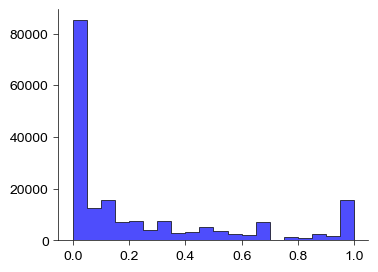

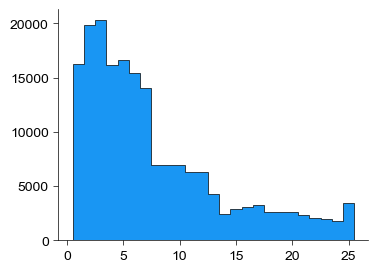

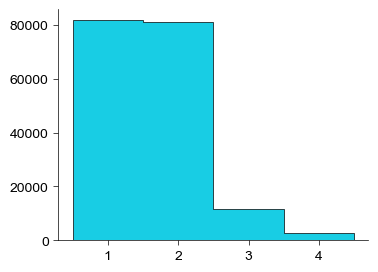

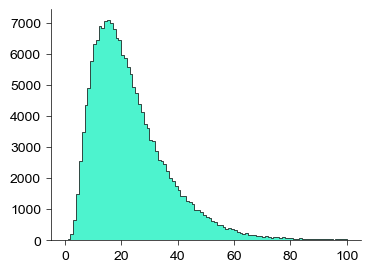

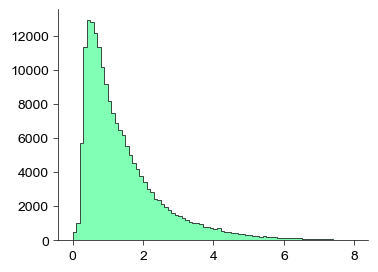

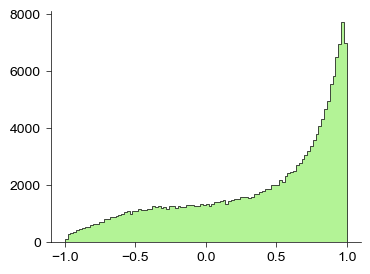

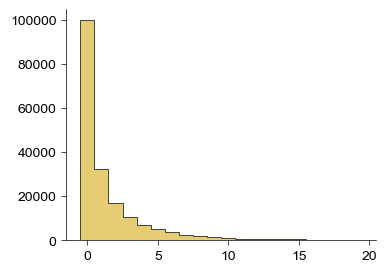

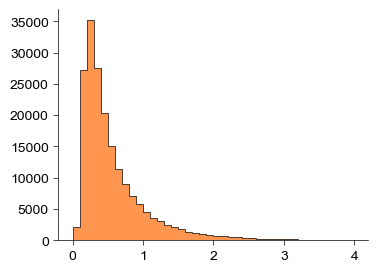

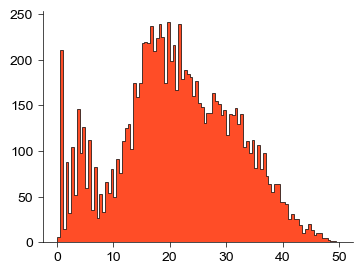

In [21]:
from mylib.statistic_test import *

code_id = '0347 - GLM Parameters Distribution'
loc = os.path.join(figpath, code_id)
mkdir(loc)

def preprocess(field_reg, GLM):
    idx = np.where(field_reg == 0)
    GLM[idx][4:] = np.nan
    # Standardization
    #for j in range(GLM.shape[2]):
    #    mean, std = np.nanmean(GLM[:, :, j]), np.nanstd(GLM[:, :, j])
    #    GLM[:, :, j] = (GLM[:, :, j] - mean) / std
    
    for j in range(GLM.shape[2]):
        vmin, vmax = np.percentile(GLM[:, :, j], [5, 95])
        GLM[:, :, j] = np.clip(GLM[:, :, j], vmin, vmax)

    GLM = GLM[:, :, [0, 1, 2, 4, 5, 6, 7, 8, 9]]
    #field_reg = field_reg[:, qualified_idx]
    tracker = Tracker2d(field_reg=field_reg)
    sequences = tracker.convert_to_sequence()
    lengths = np.array([len(seq) for seq in sequences])
    
    max_length = np.max(lengths)
    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=10, is_seq_format=True)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=5, is_seq_format=True)
    
    return sequences, glm_params

if os.path.exists(join(figdata, code_id+'.pkl')):
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
else:
    Data = {
        "Parameter": [],
        "Value": [],
        "MiceID": [],
        "Paradigm": []
    }
    
    for i in range(len(f_CellReg_modi)):
        if f_CellReg_modi['Type'][i] != 'Real' or f_CellReg_modi['maze_type'][i] == 0:
            continue
        
        print(f_CellReg_modi['Trace File'][i])
        
        with open(f_CellReg_modi['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
        
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            maze_type = int(f_CellReg_modi['maze_type'][i])
            paradigm = 'MA' if maze_type == 1 else 'MB'
        
            field_reg = trace['field_reg']
            glm_params = trace['GLM'][0]
            sequences, glm_params = preprocess(field_reg, glm_params)
            
            concat_seq = np.concatenate([seq for seq in sequences])
            params = np.vstack(glm_params)
            params = params[concat_seq==1, :]
            
            Data['MiceID'] += [mouse] * params.shape[0] * params.shape[1]
            Data['Paradigm'] += [paradigm] * params.shape[0] * params.shape[1]
            Data['Value'].append(np.concatenate([params[:, j] for j in range(params.shape[1])]))
            Data['Parameter'].append(np.concatenate([np.repeat(j, params.shape[0]) for j in range(params.shape[1])]))
        else:
            for dirs in ['cis', 'trs']:
                if f_CellReg_modi['paradigm'][i] == 'ReverseMaze':
                    paradigm = 'MAf' if dirs == 'cis' else 'MAb'
                elif f_CellReg_modi['paradigm'][i] == 'HairpinMaze':
                    paradigm = 'HPf' if dirs == 'cis' else 'HPb'
                
                mouse = int(f_CellReg_modi['MiceID'][i])
                maze_type = int(f_CellReg_modi['maze_type'][i])
                
                field_reg = trace[dirs]['field_reg']
                glm_params = trace[f'GLM_{dirs}'][0]
                
                sequences, glm_params = preprocess(field_reg, glm_params)
                
                concat_seq = np.concatenate([seq for seq in sequences])
                params = np.vstack(glm_params)
                params = params[concat_seq==1, :]   
                
                Data['MiceID'] += [mouse] * params.shape[0] * params.shape[1]
                Data['Paradigm'] += [paradigm] * params.shape[0] * params.shape[1]
                Data['Value'].append(np.concatenate([params[:, j] for j in range(params.shape[1])]))
                Data['Parameter'].append(np.concatenate([np.repeat(j, params.shape[0]) for j in range(params.shape[1])]))
                
    Data['Value'] = np.concatenate(Data['Value'])
    Data['Parameter'] = np.concatenate(Data['Parameter'])
    Data['MiceID'] = np.array(Data['MiceID'], np.int64)
    Data['Paradigm'] = np.array(Data['Paradigm'])

    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)

xlims = np.array([
    [0-1e-10, 1+1e-10, 20],
    [0.5, 25.5, 25],
    [0.5, 4.5, 4],
    [0, 100, 100],
    [0, 8, 80],
    [-1, 1, 100],
    [-0.5, 19.5, 20],
    [0, 4, 40],
    [1e-10, 50+1e-10, 100]
])
colors = sns.color_palette("rainbow", 9)
for i, k in enumerate(np.unique(Data['Parameter'])):
    idx = np.where((Data['Parameter'] == k)&(Data['Paradigm'] != 'MB'))[0]
    SubData = SubDict(Data, Data.keys(), idx=idx)
    
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    """
    sns.ecdfplot(
        x='Value',
        data=SubData,
        hue=np.array([SubData['Paradigm'][i] + str(SubData['MiceID'][i]) for i in range(len(SubData['Paradigm']))]),
        palette='Spectral',
        ax=ax
    )
    """
    ax.hist(
            SubData['Value'], 
            range=(xlims[i, 0], xlims[i, 1]), 
            bins=int(xlims[i, 2]), 
            color=colors[i],
            histtype='stepfilled',
            edgecolor='k',
            linewidth=0.5
    )
    plt.savefig(join(loc, f"Element {i}.png"), dpi=600)
    plt.savefig(join(loc, f"Element {i}.svg"), dpi=600)
    plt.show()
